# 数据

In [1]:
# 导入 TensorFlow
import tensorflow as tf
# 即显模式
tf.enable_eager_execution()
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import numpy as np
tf.set_random_seed(123)

# 生成数据
n_example = 100
X = tf.random_normal([n_example])
# 称重误差
noise = tf.random_uniform([n_example], -0.5, 0.5)
Y = X * 2 + noise

# 训练集
train_x = X[:80]
train_y = Y[:80]

# 测试集
test_x = X[80:]
test_y = Y[80:]

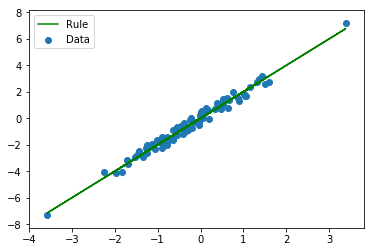

In [3]:
# 显示训练集
import matplotlib.pyplot as plt
plt.plot(train_x, train_y - noise[:80], color='green')
plt.scatter(train_x, train_y)
plt.legend(['Rule','Data'])

# 模型

In [4]:
import tensorflow.contrib.eager as tfe
# 定义模型类
class Model(object):
    def __init__(self):
        # 参数
        # 初始化：随便给 参数 W 和 b 两个值
        self.W = tfe.Variable(0.1)
        self.b = tfe.Variable(0.1)
    
    def __call__(self, x):
        # 正向传递
        # 如何利用 参数 W 和 b 运算
        y = self.W * x + self.b
        return y
# 实例模型
model = Model()

# 训练前

Final Test Loss: 2.763198
[0.2 0.3]


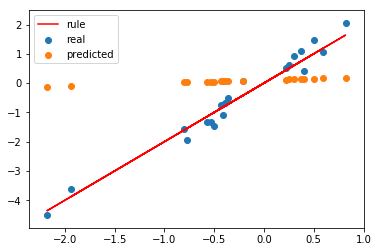

In [5]:
# 误差
def loss(prediction, label):
    loss = tf.reduce_mean(tf.square(prediction - label))
    return loss

# 评估
test_p = model(test_x)
print("Final Test Loss: %s" %loss(test_p, test_y).numpy())

# 可视化
plt.plot(test_x,test_y-noise[80:],color='red')
plt.scatter(test_x,test_y)
plt.scatter(test_x,test_p)
plt.legend(['rule','real','predicted'])

# 预测
test_p = model([1,2])
print(test_p.numpy())

# 不同样本时，w 的梯度 （不训练）

In [6]:
def change_example(i,v):
    def ew(w):
        return (w * train_x[i].numpy() + model.b.numpy() - train_y[i].numpy())**2
    grad_ew = tfe.gradients_function(ew)
    w = np.linspace(-5.0, 5.0, 100)
    w0 = model.W.numpy()

    trace1 = go.Scatter(x = w, y = ew(w),
        visible = v,mode = 'lines', name = 'e(w)')

    trace2 = go.Scatter(x = [w0,w0], y = [ew(w0),0],
        visible = v,mode = 'lines+markers', name = 'points')

    trace3 = go.Scatter(x = w, y = (grad_ew(w0)[0]*(w-w0)+ew(w0)).numpy(),
        visible = v,mode = 'lines', name = "slope at w = %.3f" %w0)

    trace4 = go.Scatter(x = [w0,w0-grad_ew(w0)[0].numpy()], y = [0,0],
        visible = v,mode = 'lines', name = "negative gradient")
    return [trace1,trace2,trace3,trace4]

# 生成 10 组
data = []
s=10
for i in range(s):
    if i !=0:
        v = False
    else:
        v = True
    data+=change_example(i,v)
    
# 可视化
steps = []
for i in range(0,len(data),4):
    step = dict(
        method = 'restyle',  
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    step['args'][1][i+1] = True
    step['args'][1][i+2] = True
    step['args'][1][i+3] = True
    
    steps.append(step)

sliders = [dict(
    active = 10,
    currentvalue = {"prefix": "train: "},
    pad = {"t": 10},
    steps = steps
)]

layout = dict(sliders=sliders,
    xaxis={
        'range': [-5,5]
    },
    yaxis={
        'range': [-2, 10]
    },)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)
#py.iplot(fig, filename='gradient_of_w_using_different_examples')

# 同一个样本，训练十次后，w 的梯度变化

In [7]:
def train_one_example(i,v):
    data=change_example(i,v)
    with tf.GradientTape() as tape:
        loss_value = loss(model(train_x[i]), train_y[i])
        dW, db = tape.gradient(loss_value, [model.W, model.b])
    model.W.assign_sub(dW * 0.1)
    model.b.assign_sub(db * 0.1)
    return data
# 生成 10 组
data = []
s=10
for i in range(s):
    if i !=0:
        v = False
    else:
        v = True
    data+=train_one_example(0,v)
# 可视化
steps = []
for i in range(0,len(data),4):
    step = dict(
        method = 'restyle',  
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    step['args'][1][i+1] = True
    step['args'][1][i+2] = True
    step['args'][1][i+3] = True
    
    steps.append(step)

sliders = [dict(
    active = 10,
    currentvalue = {"prefix": "train: "},
    pad = {"t": 10},
    steps = steps
)]

layout = dict(sliders=sliders,
    xaxis={
        'range': [-5,5]
    },
    yaxis={
        'range': [-2, 10]
    },)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)
#py.iplot(fig, filename='train_one_example_10times')

# 不同样本时，w 的梯度 （训练）

In [8]:
# 训练 50 次
data = []
s=50
for i in range(s):
    if i !=0:
        v = False
    else:
        v = True
    data+=train_one_example(i,v)
steps = []
for i in range(0,len(data),4):
    step = dict(
        method = 'restyle',  
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    step['args'][1][i+1] = True
    step['args'][1][i+2] = True
    step['args'][1][i+3] = True
    
    steps.append(step)

sliders = [dict(
    active = 10,
    currentvalue = {"prefix": "train: "},
    pad = {"t": 10},
    steps = steps
)]

layout = dict(sliders=sliders,
    xaxis={
        'range': [-5,5]
    },
    yaxis={
        'range': [-2, 10]
    },)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)
#py.iplot(fig, filename='train_one_example_10times')